In [2]:
import torch
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import seaborn as sns
import emcee
from sklearn import preprocessing
import torch.nn as nn
import functorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline

## Question:4
[2 marks] Write the Random walk Metropolis Hastings algorithms from scratch. Take 1000 samples using below given log probs and compare the mean and covariance matrix with hamiltorch’s standard HMC and emcee’s Metropolis Hastings implementation. Use 500 samples as the burn/warm up samples. Also check the relation between acceptance ratio and the sigma of the proposal distribution in your from scratch implementation. Use the log likelihood function given below.

In [3]:
import torch.distributions as D
def log_ll(omega):
#     omega = torch.tensor(omega)
    mean = torch.tensor([0., 0.])
    stddev = torch.tensor([0.5, 1.])
    return D.MultivariateNormal(mean, torch.diag(stddev**2)).log_prob(omega).sum()

In [4]:
#TODO: Compare the step size with acceptance ratio

num_samples = 1000
step_size_list = [0.05]
# uni_dist

for step_size in step_size_list:
    init_dist = D.MultivariateNormal(torch.zeros(2), step_size*torch.eye(2))
    init_sample = init_dist.sample()
    mc_samples = [init_sample.detach().numpy()]
    acc_cnt = 0
    for step_itr in range(num_samples):
        next_sample = torch.tensor(mc_samples[-1]) + init_dist.sample()
        move_crit = log_ll(next_sample) - log_ll(torch.tensor(mc_samples[-1]))
#         print(move_crit,next_sample,mc_samples[-1])
        if move_crit > torch.log(torch.rand(1)):
            mc_samples.append(next_sample.detach().numpy())
            acc_cnt +=1
        else:
            mc_samples.append(mc_samples[-1])

In [5]:
acceptance_ratio = acc_cnt/1000
acceptance_ratio

0.824

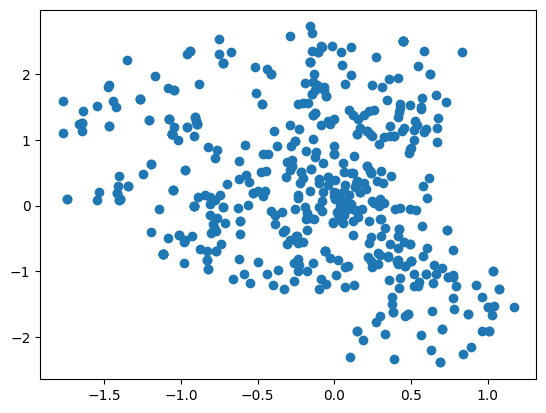

In [6]:
filt_samples = np.asarray(mc_samples)[500:,:]
plt.scatter(filt_samples[:,0],filt_samples[:,1])

In [7]:
torch.mean(torch.tensor(filt_samples),0), torch.cov(torch.tensor(filt_samples).T)

(tensor([-0.1545,  0.2766]),
 tensor([[ 0.4221, -0.2189],
         [-0.2189,  1.3409]]))

In [9]:
# HMC
import hamiltorch
hamiltorch.set_random_seed(123)
params_init = torch.zeros(2)
L = 5
params_hmc = hamiltorch.sample(log_prob_func=log_ll, params_init=params_init, num_samples=num_samples,
                               step_size=step_size_list[0], num_steps_per_sample=L)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:06 | 0d:00:00:00 | #################### | 1000/1000 | 159.89       
Acceptance Rate 1.00


In [10]:
out = torch.stack(params_hmc).detach().numpy()

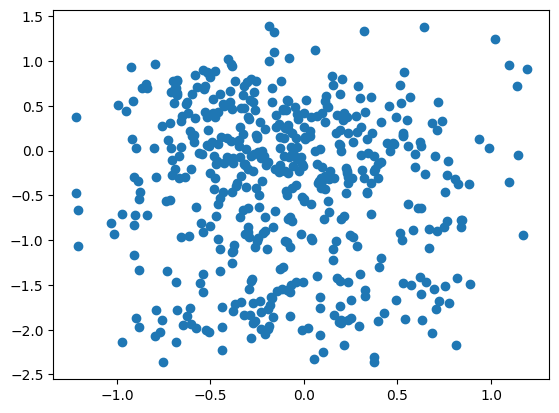

In [11]:
plt.scatter(out[500:,0],out[500:,1])

In [12]:
torch.mean(torch.stack(params_hmc),0), torch.cov(torch.stack(params_hmc).T)

(tensor([-0.0600, -0.1257]),
 tensor([[ 0.2428, -0.0583],
         [-0.0583,  0.8907]]))

In [13]:
# EMCEE implementation

In [14]:
np.random.seed(93284)
init = np.random.randn(3, 2)
nwalkers, ndim = init.shape

def log_ll_emcee(omega):
    omega = torch.tensor(omega)
    mean = torch.tensor([0., 0.])
    stddev = torch.tensor([0.5, 1.])
    return D.MultivariateNormal(mean, torch.diag(stddev**2)).log_prob(omega).sum()

sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    log_ll_emcee,
    moves=[
        (emcee.moves.GaussianMove(step_size*torch.eye(2).detach().numpy()), 1.0)
    ],
)
sampler.run_mcmc(init, 1000)

State([[0.17055597 1.61226376]
 [0.46177523 0.85700058]
 [0.55197067 1.94378988]], log_prob=[-2.50260592 -1.93842745 -3.64323282], blobs=None, random_state=('MT19937', array([4068216080, 1092642433, 3929641682, 2479657628, 3186947417,
       4012575036,  550501555,  314762673, 4107503739, 3649264328,
       4072360884, 3543947132, 1238468848, 1208915925, 3598903321,
       4013713526,  364432322, 2106992686, 2415871607,  278526421,
       2319265552,  139828279, 3556248014, 4221471803, 1124616580,
       3611941041, 3264560210, 1895611414, 2005471245, 1050881093,
       1296103456, 1497041757, 1617378553, 3022590667,  414077359,
        188012137, 1910495249, 1235803693,  684155305, 3054341906,
       1039283225, 2072831891,  931725497, 1805562589, 1672899130,
       2968009264, 3361835217, 2768940461, 1659377315,  589954861,
       4066709304, 4112205917, 1107320736, 3684135757, 3703865111,
       1066745412, 3833544387,  395305508, 1782393762, 2201921503,
        304225887, 242102496

In [15]:
sampled_obs = sampler.get_chain()[500:, 0, :]

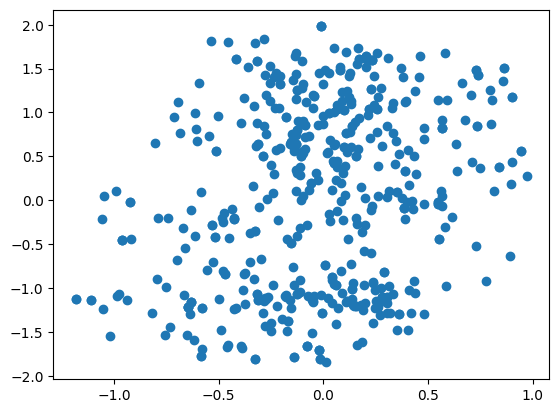

In [16]:
plt.scatter(sampled_obs[:,0],sampled_obs[:,1])

In [17]:
torch.mean(torch.tensor(sampled_obs),0), torch.cov(torch.tensor(sampled_obs).T)

(tensor([-0.0201,  0.0397], dtype=torch.float64),
 tensor([[0.1752, 0.1129],
         [0.1129, 1.0730]], dtype=torch.float64))

In [18]:
sampler.acceptance_fraction

array([0.813, 0.828, 0.831])

## Question 3 : 

In [19]:
device

device(type='cuda')

In [20]:
from astra.torch.data import load_mnist
ds=load_mnist()
ds.data.shape

/home/rishabh.mondal/miniconda3/envs/torch_env/lib/python3.11/site-packages/astra/torch/data.py:12: UserWarning: TORCH_HOME not set, setting it to /home/rishabh.mondal/.cache/torch
  warnings.warn(f"TORCH_HOME not set, setting it to {os.environ['TORCH_HOME']}")


100%|██████████| 9912422/9912422 [00:01<00:00, 7970419.99it/s] 


Extracting /home/rishabh.mondal/.cache/torch/data/MNIST/raw/train-images-idx3-ubyte.gz to /home/rishabh.mondal/.cache/torch/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 34036441.09it/s]


Extracting /home/rishabh.mondal/.cache/torch/data/MNIST/raw/train-labels-idx1-ubyte.gz to /home/rishabh.mondal/.cache/torch/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35413443.58it/s]


Extracting /home/rishabh.mondal/.cache/torch/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/rishabh.mondal/.cache/torch/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6153271.57it/s]

Extracting /home/rishabh.mondal/.cache/torch/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/rishabh.mondal/.cache/torch/data/MNIST/raw



torch.Size([70000, 28, 28])

In [21]:
# Read 1000 images from ds xarray dataset into PyTorch tensors
# print(ds['img'])
imgs = ds.data[:1000,:,:]

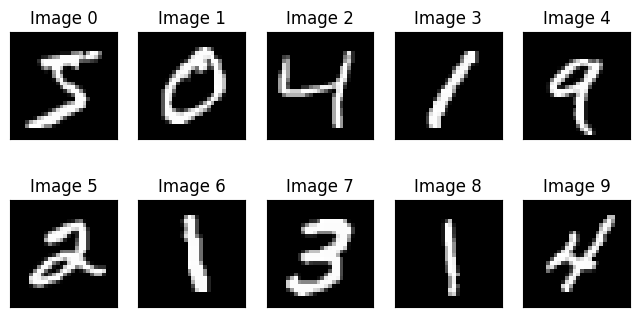

In [22]:
# Plot the first 10 images
fig, axes = plt.subplots(2, 5, figsize=(8, 4), sharex=True, sharey=True)
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(imgs[i].view(28, 28).cpu().numpy(), cmap='gray')
    ax.set_title(f'Image {i}')
    ax.set_xticks([])
    ax.set_yticks([])

In [23]:
# Create a coordinate dataset from the image
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height* width, 2) and torch.tensor containing the (num_channels)
    """
    
    num_channels=1
    height, width = img.shape
    scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
    img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)



    # Create a 2D grid of (x,y) coordinates
    x_coords = torch.arange(width).repeat(height, 1)
    y_coords = torch.arange(height).repeat(width, 1).t()
    x_coords = x_coords.reshape(-1)
    y_coords = y_coords.reshape(-1)
    
    # Combine the x and y coordinates into a single tensor
    X = torch.stack([x_coords, y_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)
#     print(type(X))
    # Create a tensor containing the image pixel values
    Y = torch.tensor(img_scaled.reshape(-1, 1)).float().to(device) # Check without .flatten()
    return X, Y

In [24]:
X,Y = create_coordinate_map(imgs[0])

# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X.cpu())

# Scale the X coordinates
X_scaled = scaler_X.transform(X.cpu())

# Move the scaled X coordinates to the GPU
X_scaled = torch.tensor(X_scaled).to(device)

# Set to dtype float32
X_scaled = X_scaled.float()
# num_channels, height, width = imgs[0].shape
# img = imgs[0]
X_scaled

tensor([[-1.0000, -1.0000],
        [-0.9259, -1.0000],
        [-0.8519, -1.0000],
        ...,
        [ 0.8519,  1.0000],
        [ 0.9259,  1.0000],
        [ 1.0000,  1.0000]], device='cuda:0')

In [25]:
# Create a MLP with 5 hidden layers with 256 neurons each and ReLU activations.
# Input is (x, y) and output is (r, g, b) or (g) for grayscale

s = 128

class NN(nn.Module):
    def _init_siren(self, activation_scale):
        self.fc1.weight.data.uniform_(-1/self.fc1.in_features, 1/self.fc1.in_features)
        for layers in [self.fc2, self.fc3, self.fc4, self.fc5]:
            layers.weight.data.uniform_(-np.sqrt(6/self.fc2.in_features)/activation_scale, 
                                        np.sqrt(6/self.fc2.in_features)/activation_scale)
        
    def __init__(self, activation=torch.sin, n_out=1, activation_scale=1.0):
        super().__init__()
        self.activation = activation    
        self.activation_scale = activation_scale
        self.fc1 = nn.Linear(2, s)
        self.fc2 = nn.Linear(s, s)
        self.fc3 = nn.Linear(s, s)
        self.fc4 = nn.Linear(s, s)
        self.fc5 = nn.Linear(s, n_out) #gray scale image (1) or RGB (3)
        if self.activation == torch.sin:
            # init weights and biases for sine activation
            self._init_siren(activation_scale=self.activation_scale)

    def forward(self, x):
        x = self.activation(self.activation_scale*self.fc1(x))
        x = self.activation(self.activation_scale*self.fc2(x))
        x = self.activation(self.activation_scale*self.fc3(x))
        x = self.activation(self.activation_scale*self.fc4(x))
        return self.fc5(x)

In [26]:
class HyperNet(nn.Module):
    def __init__(self, activation=torch.sin, n_out=50049):
        super().__init__()
        self.activation = activation
        self.fc1 = nn.Linear(3, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, n_out)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return self.fc3(x)

In [27]:
hp = HyperNet().to(device)

In [28]:
try:
    from tabulate import tabulate
except:
    %pip install tabulate
    from tabulate import tabulate

model = NN(activation=torch.sin, n_out=1, activation_scale=30.0).to(device)

table_data = []

total_params = 0
start = 0
start_end_mapping = {}
for name, param in model.named_parameters():
    param_count = torch.prod(torch.tensor(param.shape)).item()
    total_params += param_count
    end = total_params
    table_data.append([name, param.shape, param_count, start, end])
    start_end_mapping[name] = (start, end)
    start = end

print(tabulate(table_data, headers=["Layer Name", "Shape", "Parameter Count", "Start Index", "End Index"]))
print(f"Total number of parameters: {total_params}")

Layer Name    Shape                     Parameter Count    Start Index    End Index
------------  ----------------------  -----------------  -------------  -----------
fc1.weight    torch.Size([128, 2])                  256              0          256
fc1.bias      torch.Size([128])                     128            256          384
fc2.weight    torch.Size([128, 128])              16384            384        16768
fc2.bias      torch.Size([128])                     128          16768        16896
fc3.weight    torch.Size([128, 128])              16384          16896        33280
fc3.bias      torch.Size([128])                     128          33280        33408
fc4.weight    torch.Size([128, 128])              16384          33408        49792
fc4.bias      torch.Size([128])                     128          49792        49920
fc5.weight    torch.Size([1, 128])                  128          49920        50048
fc5.bias      torch.Size([1])                         1          50048      

In [29]:
from astra.torch.utils import ravel_pytree
flat_weights, unravel_fn = ravel_pytree(dict(model.named_parameters()))



In [30]:
def train(hypernet,full_net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(hypernet.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = full_net(X,Y)
        
#         print(outputs.shape, Y.flatten().shape)
        loss = criterion(outputs, Y.flatten())
        loss.backward()
#         for param in hypernet.parameters():
#             print(param.name, param.data)
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()



In [31]:
def hypernet_with_target(X,Y):
    # Concatenate x_c and y_c to form the context
    context = torch.cat([X, Y.view(-1, 1)], dim=1)
#     print(context)
    out_hp = hp(context.to(device))
    weights_flattened  = out_hp.mean(dim=0)
    target = unravel_fn(weights_flattened)
#     print(model.state_dict(),target)
#     model.load_state_dict(target)
#     y_pred = model(X.to(device)).flatten()
#     target_state_dict=model.state_dict()
#     for param_key in target_state_dict:
#         target_state_dict[param_key] = target[param_key]
#     model.load_state_dict(target_state_dict)
#     fmodel, params = functorch.make_functional(model)
    
#     print(target_state_dict)
#     print(target)
#     print(params)
#     y_pred = fmodel(params, X.to(device)).ravel()
    
    y_pred = torch.func.functional_call(model, target, X.to(device)).ravel()
    return y_pred

In [35]:
train(hypernet=hp,full_net = hypernet_with_target, lr=3e-4, X=X_scaled, Y=Y, epochs=1000)

# train(nns["dog"]["relu"], lr=3e-4, X=dog_X_sh, Y=dog_Y_sh, epochs=n_iter)

Epoch 0 loss: 0.150688
Epoch 100 loss: 0.138577
Epoch 200 loss: 0.143231
Epoch 300 loss: 0.135118
Epoch 400 loss: 0.142368
Epoch 500 loss: 0.140569
Epoch 600 loss: 0.144205
Epoch 700 loss: 0.171813
Epoch 800 loss: 0.156645
Epoch 900 loss: 0.131612


0.1506611704826355

In [33]:
# get x,y,intensity dataset from mnist for 5 numbers



coord = CoordMLP()

# Fit the model on the first image
optimizer = torch.optim.Adam(coord.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Create input to the model
x = torch.linspace(-1, 1, 28)
y = torch.linspace(-1, 1, 28)

# Create a grid of x and y
x_grid, y_grid = torch.meshgrid(x, y)

# Flatten the grid
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Concatenate x and y to form the input
inp = torch.cat([x_flat.view(-1, 1), y_flat.view(-1, 1)], dim=1)

# Create the target
target = imgs[0].flatten()
print(target.shape,inp.shape)


NameError: name 'CoordMLP' is not defined

In [ ]:
for epoch in range(1000):
    optimizer.zero_grad()

    pred = coord(inp)
    l = criterion(pred.flatten(), target) # Used flatten since broadcasting results in an error
    l.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch} loss {l:.2f}')